In [1]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 다운로드 함수
import gdown, zipfile, os, glob, shutil
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/전력수요예측/'

# 불러오기
X = np.load(path+'X_train_24.npy')
Y = np.load(path+'Y_train_24.npy')

print(X.shape)
print(Y.shape)

(7585926, 24, 13)
(7585926, 1)


In [4]:
# train_test_split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

del X, Y

## 모델링

In [5]:
from sklearn.metrics import *

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# 메모리 정리
clear_session()

# 모델 선언
model = Sequential()
model.add(Input(shape=(24,13)))
model.add(LSTM(16,return_sequences=True))
model.add(LSTM(4,return_sequences=True))
model.add(LSTM(1,return_sequences=True))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 16)            1920      
                                                                 
 lstm_1 (LSTM)               (None, 24, 4)             336       
                                                                 
 lstm_2 (LSTM)               (None, 24, 1)             24        
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2489 (9.72 KB)
Trainable params: 2489 (9.7

In [7]:
model.compile(loss='mse', optimizer=Adam(0.005), metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15,verbose=1,restore_best_weights=True)

cp_path = path+'모델 자동저장/LSTM1_{epoch:03d}.h5'
mcp = ModelCheckpoint(cp_path, monitor='val_loss', verbose = 1, save_best_only=True)

history = model.fit(x_train, y_train,
                    batch_size=50000, validation_split=0.2,
                    callbacks=[es, mcp], epochs=1000).history

Epoch 1/1000
97/98 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0562
Epoch 1: val_loss improved from inf to 0.00317, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/LSTM1_001.h5
98/98 [==============================] - 20s 149ms/step - loss: 0.0055 - mae: 0.0562 - val_loss: 0.0032 - val_mae: 0.0417
Epoch 2/1000
97/98 [============================>.] - ETA: 0s - loss: 0.0024 - mae: 0.0363
Epoch 2: val_loss improved from 0.00317 to 0.00184, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/LSTM1_002.h5
98/98 [==============================] - 9s 94ms/step - loss: 0.0024 - mae: 0.0363 - val_loss: 0.0018 - val_mae: 0.0309
Epoch 3/1000
97/98 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0275
Epoch 3: val_loss improved from 0.00184 to 0.00097, saving model to /content/drive/MyDrive/전력수요예측/모델 자동저장/LSTM1_003.h5
98/98 [==============================] - 9s 94ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 9.6840e-04

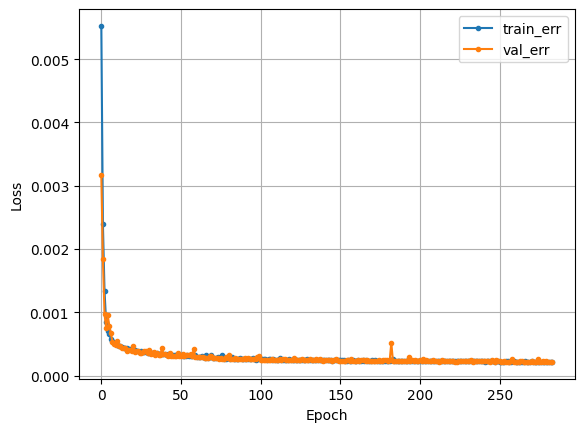

In [8]:
dl_history_plot(history)